In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from tqdm import trange
from numba import jit
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
def Heun(func,y0,t0,n,h, const):
    y = np.zeros((n,np.shape(y0)[0],np.shape(y0)[1]))
    y[0,:,:] = y0
    yp = np.zeros_like(y0)
    t = np.zeros(n)

    for i in range(1,n):
        yp = y[i-1,:,:] + h*func(h*(i-1),y[i-1,:,:],const)
        y[i,:,:] = y[i-1,:,:] + (h/2)*(func(h*(i-1),y[i-1,:,:],const) + func(h*i,yp,const))
        t[i] = h*i
    return y, t


def LLG(t,y,const):
    gamma, mu, alpha, J, dz, B = const
    dH = -dHdS(y,J,dz,mu,B)
    yxdH = np.cross(y,dH)
    return -gamma/(mu*(1+alpha**2))*(yxdH+alpha*np.cross(y,yxdH))


def dHdS(S,J,dz,mu,B):
    dH = np.empty_like(S)
    # 1 spin
    if np.size(S) == 3:
        dH[0,:2] = -mu*B[:2]
        dH[0,2] = -2*dz*S[0,2]-mu*B[2]
    #  2 spins
    elif np.size(S) == 6:
        dH[0,:2] = -0.5*J*S[1,:2]-mu*B[:2]
        dH[0,2] = -0.5*J*S[1,2]-2*dz*S[0,2]-mu*B[2]
        dH[1,:2] = -0.5*J*S[0,:2]-mu*B[:2]
        dH[1,2] = -0.5*J*S[0,2]-2*dz*S[1,2]-mu*B[2]
    # Many spins
    else:
        dH[0,:2] = -0.5*J*S[1,:2]-mu*B[:2]
        dH[0,2] = -0.5*J*S[1,2]-2*dz*S[0,2]-mu*B[2]
        dH[1:-1,:2] = -0.5*J*(S[0:-2,:2]+S[2:,:2])-mu*B[:2]
        dH[1:-1,2] = -0.5*J*(S[0:-2,2]+S[2:,2])-2*dz*S[1:-1,2]-mu*B[2]
        dH[-1,:2] = -0.5*J*S[-2,:2]-mu*B[:2]
        dH[-1,2] = -0.5*J*S[-2,2]-2*dz*S[-1,2]-mu*B[2]
    return dH
    

In [4]:
def Euler(func,y0,t0,n,h, const):
    y = np.zeros((n,np.shape(y0)[0],np.shape(y0)[1]))
    y[0,:,:] = y0
    t = np.zeros(n)
    for i in range(1,n):
        y[i,:,:] = y[i-1] + func(h*(i-1),y[i-1,:,:],const)*h
        t[i] = h*i
    return y,t

## Problem 1.1

In [5]:
gamma = 1
mu = 1
alpha = 0
J = 0
dz = 0
y0 = np.array([[0,0.1,np.sqrt(1-0.1**2)]])
B = np.array([0,0,1])
const = [gamma, mu, alpha , J, dz, B]
h = 0.01
n = int(2*np.pi/h)
y,t = Heun(LLG,y0,0,n,h, const)

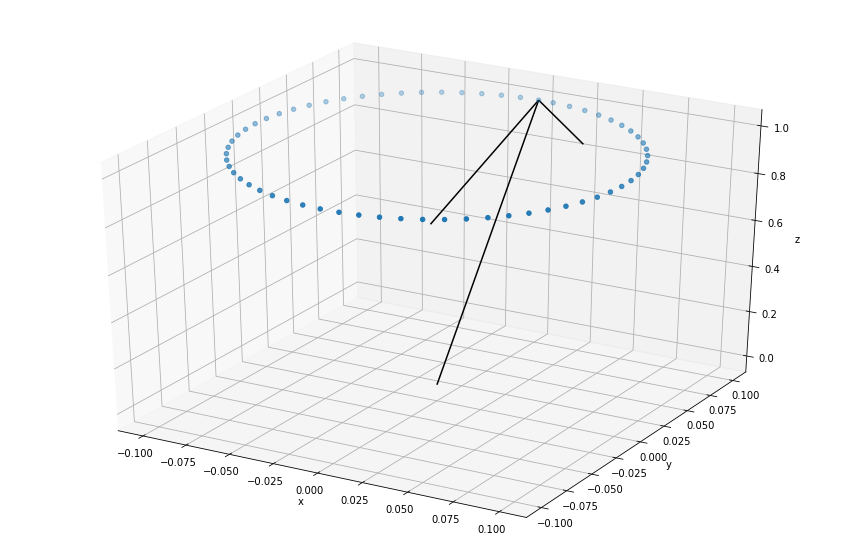

In [6]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')


ax.quiver(0,0,0,y[0,0,0],y[0,0,1],y[0,0,2],color = 'k', length = 1, normalize = True)

ax.scatter(y[::10,0,0], y[::10,0,1], y[::10,0,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.savefig(f'E2P1.1.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 1.2

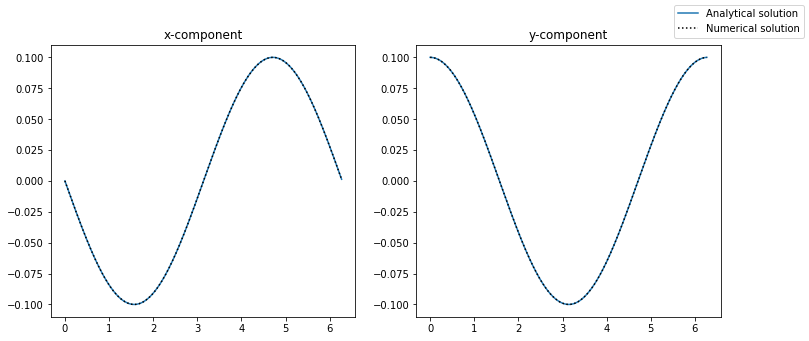

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (12,5))

axes[0].set_title('x-component')
axes[0].plot(t,-0.1*np.sin(gamma*np.sqrt(np.sum(B**2))*t), label = 'Analytical solution')
axes[0].plot(t,y[:,0,0], ':',label = 'Numerical solution',c='k')


axes[1].set_title('y-component')
axes[1].plot(t,0.1*np.cos(gamma*np.sqrt(np.sum(B**2))*t))
axes[1].plot(t,y[:,0,1],':',c='k')

fig.legend()
plt.savefig(f'E2P1.2a.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
ha = np.logspace(-5,-1,5)
ErrorH = np.zeros(5)
ErrorE = np.zeros(5)

gamma = 1
mu = 1
alpha = 0
J = 0
dz = 0
y0 = np.array([[0,0.1,np.sqrt(1-0.1**2)]])
B = np.array([0,0,1])
const = [gamma, mu, alpha , J, dz, B]

for i in range(5):
    hi = ha[i]
    n = int(0.1*np.pi/hi)
    yH,tH = Heun(LLG,y0,0,n,hi, const)
    yE,tE = Euler(LLG,y0,0,n,hi, const)
    ErrorH[i] = np.abs(0.1*np.sin(gamma*np.sqrt(np.sum(B**2))*tH[-1])+yH[-1,0,0])
    ErrorE[i] = np.abs(0.1*np.sin(gamma*np.sqrt(np.sum(B**2))*tE[-1])+yE[-1,0,0])

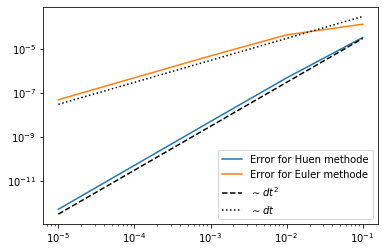

In [9]:
plt.plot(ha,ErrorH, label = 'Error for Huen methode')
plt.plot(ha,ErrorE, label = 'Error for Euler methode')
plt.xscale('log')
plt.yscale('log')
plt.plot(ha,3E-3*ha**2, '--',label = '$\sim dt^2$',c = 'k')
plt.plot(ha,3E-3*ha,':', label = '$\sim dt$',c = 'k')
plt.legend()
plt.savefig(f'E2P1.2b.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 1.3

In [30]:
gamma = 1
mu = 1
alpha = np.array([0.05,0.1,0.2])
J = 0
dz = 0
y0 = np.array([[0,0.1,np.sqrt(1-0.1**2)]])
B = np.array([0,0,1])
const = [gamma, mu, alpha , J, dz, B]
h = 0.01
n = int(15*np.pi/h)
yd,td = Heun(LLG,y0,0,n,h, const)
tau = 1/(alpha*gamma*np.sqrt(np.sum(B**2)))

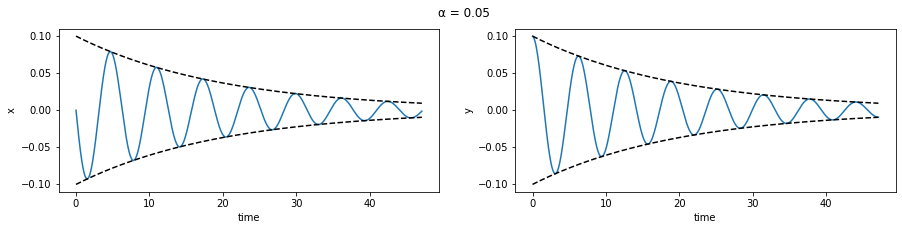

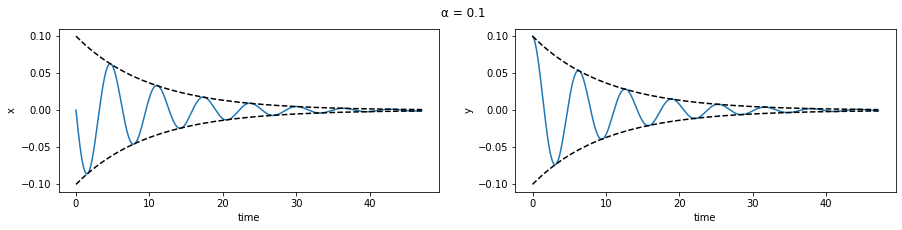

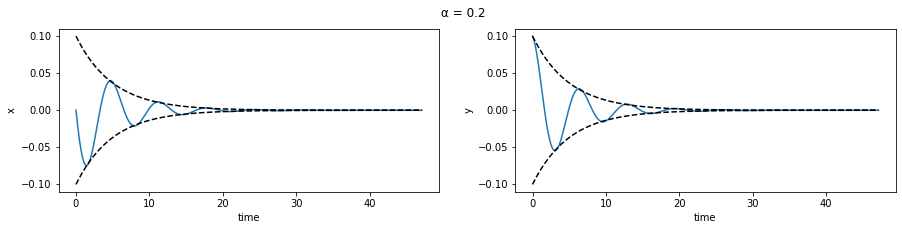

In [11]:
for a in alpha:
    const = [gamma, mu, a , J, dz, B]
    yd,td = Heun(LLG,y0,0,n,h, const)
    tau = 1/(a*gamma*np.sqrt(np.sum(B**2)))
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 3))
    fig.suptitle(f'α = {a}')
    # x-component
    axes[0].plot(td,yd[:,0,0])
    axes[0].plot(td,-y0[0,1]*np.exp(-(td/tau)),linestyle='dashed',color = 'k')
    axes[0].plot(td,y0[0,1]*np.exp(-(td/tau)),linestyle='dashed',color = 'k')
    axes[0].set_ylabel('x')
    axes[0].set_xlabel('time')
    
    #y-component
    axes[1].plot(td,yd[:,0,1])
    axes[1].plot(td,-y0[0,1]*np.exp(-(td/tau)),linestyle='dashed',color = 'k')
    axes[1].plot(td,y0[0,1]*np.exp(-(td/tau)),linestyle='dashed',color = 'k')
    axes[1].set_xlabel('time')
    axes[1].set_ylabel('y')
    plt.savefig(f'E2P1.3_{a}.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
    plt.show()

## Problem 2.1

In [31]:
def RandomSpins(N):
    y0 = 1-2*np.random.random((N,3))
    norm = np.sqrt(np.sum(y0**2,axis=1))
    y0[:,0] = y0[:,0]/norm
    y0[:,1] = y0[:,1]/norm
    y0[:,2] = y0[:,2]/norm
    return y0

In [34]:
gamma = 1
mu = 1
alpha = 0.05
dz = 0.1
B = np.array([0,0,0])

Jp = 4
const1 = [gamma, mu, alpha , Jp, dz, B]

y0 = RandomSpins(10)
h = 0.01
n = int(50*np.pi/h)

yp,tp = Heun(LLG,y0,0,n,h, const1)

Jn = -4
const2 = [gamma, mu, alpha , Jn, dz, B]

yn,tn = Heun(LLG,y0,0,n,h, const2)

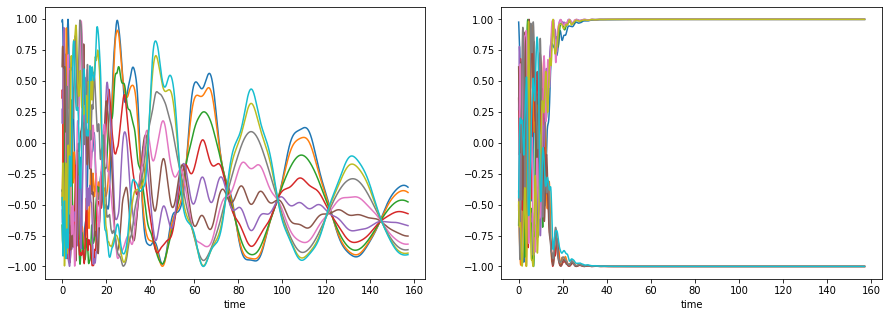

In [35]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(tp,yp[:,:,2])
ax[0].set_xlabel('time')
ax[1].plot(tp,yn[:,:,2])
ax[1].set_xlabel('time')
plt.savefig(f'E2P2.1.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

## Problem 2.2

In [15]:
## 2.2.2.1
gamma = 1
mu = 1
alpha = 0
J = 0
dz = 1
B = np.array([0,0,0])
const = [gamma, mu, alpha , J, dz, B]

h = 0.01
n = int(10*np.pi/h)

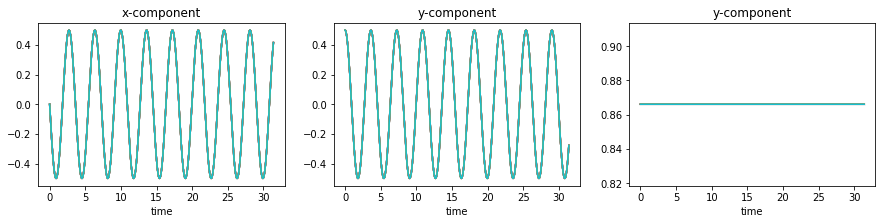

In [16]:
#All spins tilted, no couling
y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)

y0[:,1] = 0.5*np.ones(10)
y0[:,2] = np.sqrt(1-0.5**2)*np.ones(10)
y,t = Heun(LLG,y0,0,n,h, const)
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
ax[0].set_title('x-component')
ax[0].set_xlabel('time')
ax[0].plot(t,y[:,:,0])
ax[1].set_title('y-component')
ax[1].set_xlabel('time')
ax[1].plot(t,y[:,:,1])
ax[2].set_title('y-component')
ax[2].set_xlabel('time')
ax[2].plot(t,y[:,:,2])
plt.savefig(f'E2P2.2a.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

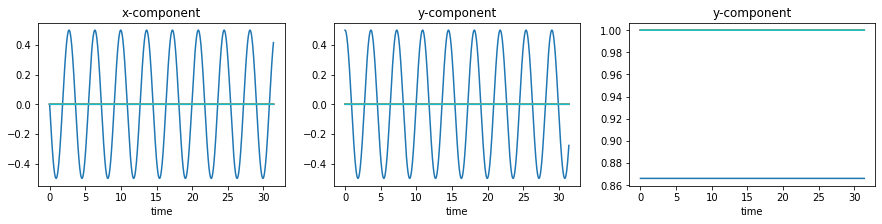

In [17]:
# One spin tilted, no couling
y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[0,1] = 0.5
y0[0,2] = np.sqrt(1-0.5**2)
y,t = Heun(LLG,y0,0,n,h, const)
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

ax[0].set_title('x-component')
ax[0].set_xlabel('time')
ax[0].plot(t,y[:,:,0])
ax[1].set_title('y-component')
ax[1].set_xlabel('time')
ax[1].plot(t,y[:,:,1])
ax[2].set_title('y-component')
ax[2].set_xlabel('time')
ax[2].plot(t,y[:,:,2])
#plt.savefig(f'E2P2.2b.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
## 2.2.2.2

gamma = 1
mu = 1
alpha = 0
J = 1
dz = 1
B = np.array([0,0,0])
const = [gamma, mu, alpha , J, dz, B]
h = 0.01
n = int(5*np.pi/h)

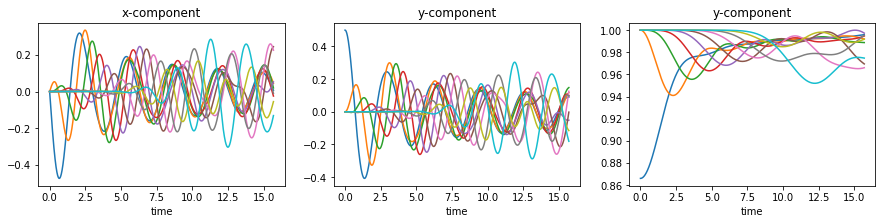

In [19]:
# First spin tilted
y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[0,1] = 0.5
y0[0,2] = np.sqrt(1-0.5**2)
yf,t = Heun(LLG,y0,0,n,h, const)
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

ax[0].set_title('x-component')
ax[0].set_xlabel('time')
ax[0].plot(t,yf[:,:,0])
ax[1].set_title('y-component')
ax[1].set_xlabel('time')
ax[1].plot(t,yf[:,:,1])
ax[2].set_title('y-component')
ax[2].set_xlabel('time')
ax[2].plot(t,yf[:,:,2])
plt.savefig(f'E2P2.2c.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Last spin tilted
y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[-1,1] = 0.5
y0[-1,2] = np.sqrt(1-0.5**2)
yl,t = Heun(LLG,y0,0,n,h, const)

In [21]:
#Middel spin tilted
y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[5,1] = 0.5
y0[5,2] = np.sqrt(1-0.5**2)
ym,t = Heun(LLG,y0,0,n,h, const)

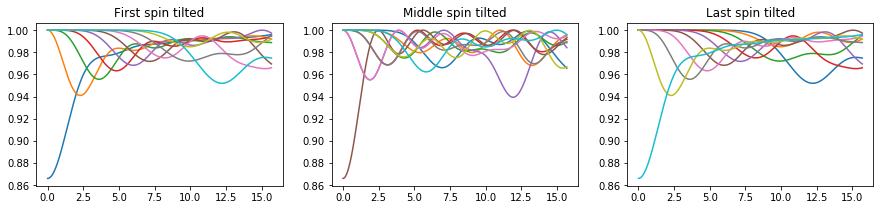

In [22]:
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

ax[0].set_title('First spin tilted')
ax[0].plot(t,yf[:,:,2])
ax[1].set_title('Middle spin tilted')
ax[1].plot(t,ym[:,:,2])
ax[2].set_title('Last spin tilted')
ax[2].plot(t,yl[:,:,2])
plt.savefig(f'E2P2.2d.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
def get_arrow(i,s):
    x = np.arange(-len(s[0,:,0])/2, len(s[0,:,0])/2)
    y = np.zeros(len(s[0,:,0]))
    z = np.zeros(len(s[0,:,0]))
    u = s[i,:,0] 
    v = s[i,:,1] 
    w = s[i,:,2]
    return x,y,z,u,v,w

def animate(i,s):
    global quiver
    quiver.remove()
    quiver = ax.quiver(*get_arrow(int(i),s), length = 1, normalize = True)
    
    
    
def animateManySpins(s):
    global ax
    global quiver
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca(projection='3d')
    ax.set_xlim(-6,6)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    
    x, y, z = np.arange(-len(s[0,:,0])/2, len(s[0,:,0])/2), np.zeros(len(s[0,:,0])), np.zeros(len(s[0,:,0]))
    quiver = ax.quiver(x, y, z, s[0, :, 0], s[0, :, 1], s[0, :, 2], length = 1, normalize = True)

    anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0,s.shape[0]-1,100),fargs=(s,))

    video = anim.to_html5_video()
    html = HTML(video)
    display(html)
    plt.close()
    return anim

def saveAnimation(anim,text):
    anim.save(f'animation'+text+'.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [24]:
#Only first spin tilted
anim = animateManySpins(yf)
saveAnimation(anim,f'2.2.2_First')

In [25]:
#Only middle spin tilted
anim = animateManySpins(ym)
saveAnimation(anim,f'2.2.2_MiddleTilted')

In [26]:
#Only last spin tilted
anim = animateManySpins(yf)
saveAnimation(anim,f'2.2.2_LastTilted')

## Problem 2.4

In [27]:
## With damping

gamma = 1
mu = 1
alpha = 0.05
J = 1
dz = 1
B = np.array([0,0,0])
const = [gamma, mu, alpha , J, dz, B]

h = 0.01
n = int(10*np.pi/h)

y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[5,1] = 0.5
y0[5,2] = np.sqrt(1-0.5**2)
s,t = Heun(LLG,y0,0,n,h, const)

anim = animateManySpins(s)
saveAnimation(anim,f'2.2.4')

In [28]:
## Antiferromagnetic

gamma = 1
mu = 1
alpha = 0.05
J = -3
dz = 1
B = np.array([0,0,0])
const = [gamma, mu, alpha , J, dz, B]

h = 0.01
n = int(40*np.pi/h)

y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[4,1] = 0.5
y0[4,2] = np.sqrt(1-0.5**2)
s,t = Heun(LLG,y0,0,n,h, const)

anim = animateManySpins(s)
saveAnimation(anim,f'2.2.5')

## Problem 2.2.6

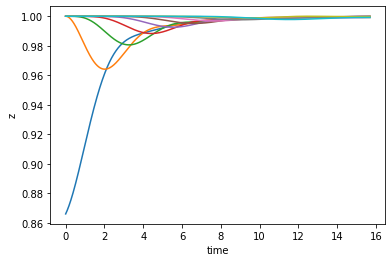

In [29]:
gamma = 1
mu = 1
alpha = 0.05
J = 1
dz = 1
B = np.array([0,0,0])
const = [gamma, mu, alpha , J, dz, B]
h = 0.01
n = int(5*np.pi/h)

# First spin tilted
y0 = np.zeros((10,3))
y0[:,2] = np.ones(10)
y0[0,1] = 0.5
y0[0,2] = np.sqrt(1-0.5**2)
y,t = Heun(LLG,y0,0,n,h, const)

plt.plot(t,y[:,:,2])
plt.ylabel('z')
plt.xlabel('time')
plt.savefig(f'E2P2.6.pdf', format = 'pdf', dpi=300, bbox_inches='tight')
plt.show()